# **Part I - Loading the dataset**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#1) ensure the correct version of Tensorflow is installed, 2.1.0.
#!pip install tensorflow==2.1.0
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

#run tutorial or lab3
boolSRCIM = True
boolAugumentation = False

2.3.0


In [ ]:
#2) download the dataset .zip from the Google Drive link
if boolSRCIM:
  !gdown --id "1rtLYlLQ9QIMEb5v2eH1D9mu7FpgOqzYq" #lab3
else:
  !gdown --id "1To2deR_oTXn6yL2hTvVplqt3Iv2gMcPp" #tutorial

Downloading...
From: https://drive.google.com/uc?id=1rtLYlLQ9QIMEb5v2eH1D9mu7FpgOqzYq
To: /content/dataset_lab3_SRCIM_400.zip
13.5MB [00:00, 82.3MB/s]


In [ ]:
#3) extract the dataset folder.
import os      #to get access to the file system
import zipfile #to unzip the data

if boolSRCIM:
  local_zip = '/content/dataset_lab3_SRCIM_400.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()
  #zip content extracted to the directory data_root
  data_root = "/tmp/dataset"
else: # TUTORIAL
  local_zip = '/content/tutorial_dataset_SRCIM.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()
  #zip content extracted to the directory data_root
  data_root = "/tmp/tutorial_dataset"

# **Part II – Pre-processing the data**

In [ ]:
#1) prepare configurations
#1.1) all images resized to 224x224
IMAGE_SHAPE = (224,224)
TRAINING_DATA_DIR = str(data_root)
#1.2) rescale pixel to 0-1 and separate data between validation and training data
if boolAugumentation:
  datagen_kwargs = dict(
    rescale = 1./255,
    validation_split = .20,
    # Data Augmentation arguments for better validation
    width_shift_range = 0.15, #0.15
    height_shift_range = 0.15, #0.15
    horizontal_flip = True
  )
else:
  datagen_kwargs = dict(
    rescale = 1./255,
    validation_split = .20
  )  

In [ ]:
#2) generate batches of image data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs) #**datagen_kwargs
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset = "training",
    shuffle = True,
    target_size = IMAGE_SHAPE
)
#preprocessing_function = tf.keras.applications.vgg16.preprocess_input
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs) #**datagen_kwargs
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset = "validation",
    shuffle = True,
    target_size = IMAGE_SHAPE
)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


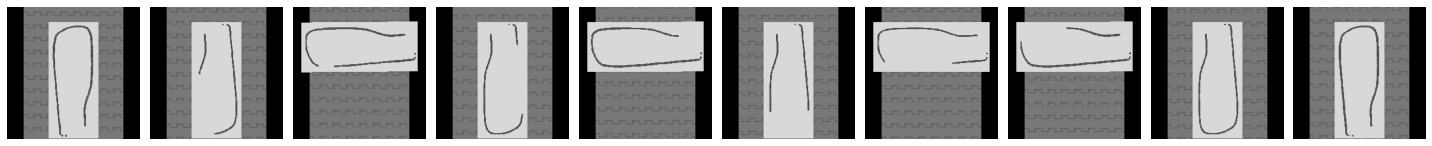

In [ ]:
#3) see images
imgs, labels = next(train_generator)
fid, axes = plt.subplots(1, 10, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(imgs, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# **Part III – Building the CNN model from scratch**

In [ ]:
#1) instantiate a Sequential model
model = tf.keras.models.Sequential()

In [ ]:
#2) define the architecture of the CNN
#2.1) add activation layer (CONVOLUTIONAL LAYER)
model.add(tf.keras.layers.Conv2D(
    filters = 64,    #             #NUMBER OF FILTERS TO BE USED FOR CONVOLUTION
    kernel_size = (3,3),          #FILTER SIZE
    input_shape = (224, 224, 3),  #INPUT SHAPE OF THE IMAGES(NUMBER OF ROWS, NUMBER OF COLUMNS, color CHANNELS)
    padding='same',
    activation = 'relu'           #ACTIVATION FUNCTION
))

In [ ]:
#3) add pooling layer 
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides=2)) #strides=2

In [ ]:
#4.1) add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters = 128,#128
    kernel_size = (3,3),
    padding='same',
    activation = 'relu'
))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides=2))

#4.2) add third convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters = 256,#256
    kernel_size = (3,3),
    padding='same',
    activation = 'relu'
))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides=2))

In [ ]:
#5) flatten the pooled feature map into a column (vector) to be passed as input to the artificial neural network
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dropout(0.3)) #0.5

In [ ]:
#6) add the fully-connected layer with a rectified linear unit (ReLU) activation
model.add(tf.keras.layers.Dense(256)) 
model.add(tf.keras.layers.Activation('relu'))

In [ ]:
#7) add the output layer
model.add(tf.keras.layers.Dense(train_generator.num_classes, activation='sigmoid')) #sigmoid para binary e softmax para categorical

In [ ]:
#8) build the model and print a summary of the architecture
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [ ]:
#9) compile the model

optimizer = tf.keras.optimizers.Adam(lr=1e-4) #learning_rate=0.0001
model.compile( #lr=1e-3
    optimizer = optimizer,
    loss = 'binary_crossentropy', 
    metrics = ['acc']
)

# **Part IV – Model training and validation**

In [ ]:
#1) fit model to the training data
import numpy as np
import warnings
warnings.filterwarnings("ignore")

callbacks = [tf.keras.callbacks.EarlyStopping(patience=12)]

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
    train_generator,
    epochs = 20,
    verbose = 1,
    callbacks = callbacks,
    steps_per_epoch = steps_per_epoch,
    validation_data = valid_generator,
    validation_steps = val_steps_per_epoch
).history


Epoch 1/20
10/10 [==============================] - 2s 217ms/step - loss: 0.6984 - acc: 0.5031 - val_loss: 0.6955 - val_acc: 0.5000
Epoch 2/20
10/10 [==============================] - 2s 183ms/step - loss: 0.6805 - acc: 0.5500 - val_loss: 0.7024 - val_acc: 0.5000
Epoch 3/20
10/10 [==============================] - 2s 183ms/step - loss: 0.6639 - acc: 0.5500 - val_loss: 0.7137 - val_acc: 0.4625
Epoch 4/20
10/10 [==============================] - 2s 180ms/step - loss: 0.6286 - acc: 0.6906 - val_loss: 0.6923 - val_acc: 0.6125
Epoch 5/20
10/10 [==============================] - 2s 180ms/step - loss: 0.5954 - acc: 0.7156 - val_loss: 0.6801 - val_acc: 0.6000
Epoch 6/20
10/10 [==============================] - 2s 183ms/step - loss: 0.5335 - acc: 0.7812 - val_loss: 0.6420 - val_acc: 0.7125
Epoch 7/20
10/10 [==============================] - 2s 179ms/step - loss: 0.4594 - acc: 0.8875 - val_loss: 0.5339 - val_acc: 0.7000
Epoch 8/20
10/10 [==============================] - 2s 179ms/step - loss: 0.

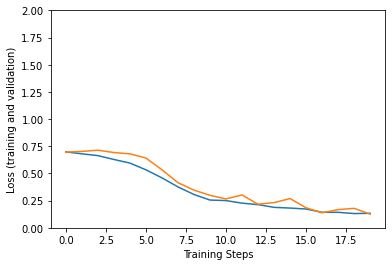

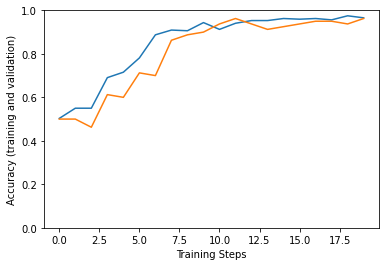

In [ ]:
#2) visualize training history in terms of accuracy and loss
 
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0, 1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])



---

# Result

In [ ]:
#3) check the final loss and accuracy results for the validation set
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}".format(final_accuracy*100))

3/3 [==============================] - 0s 62ms/step - loss: 0.1256 - acc: 0.9625
Final loss: 0.13
Final accuracy: 96.25


In [ ]:
#4) save the trained model
result = str(int(final_loss*100)) + "_" + str(int(final_accuracy*100))
model.save("srcim_model" + result + ".h5") #save model
model.save_weights("srcim_model_weights" + result + ".h5") #save only the weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#from tensorflow.keras.models import load_model
#new_model = load_model('srcim_model23_92.h5')
#new_model.summary()


# **TEAKS**

activation 

number of filters

number of layers

number of conv layers

order of layers